In [1]:
%load_ext autoreload
%autoreload 2
import os
import cv2
import PIL
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from meter_digits_recognizer import Net

In [2]:
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(1)

# Split training and testing data

In [3]:
dataset_dir = "images"
input_filenames = []
input_labels = []
for sub_dir in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]:
    for fn in os.listdir(os.path.join(dataset_dir, sub_dir)):
        if not fn.endswith(".jpg"):
            continue
        img_file = os.path.join(dataset_dir, sub_dir, fn)
        input_filenames.append(img_file)
        input_labels.append(int(sub_dir))
indices = np.arange(len(input_filenames))
np.random.shuffle(indices)
split_index = int(0.2 * len(indices))
test_indices, train_indices = indices[:split_index], indices[split_index:]
print("Test %d, train %d" % (len(test_indices), len(train_indices)))

Test 186, train 746


# Init datasets and dataloaders

In [4]:
class DigitsDataset(Dataset):
  
    def __init__(self, indices, input_filenames, input_labels, transform=None):
        self.transform = transform
        self.images = []
        self.labels = []
        for i in indices:
            img = cv2.imread(input_filenames[i])
            resized = cv2.resize(img, (20, 32), interpolation=cv2.INTER_LINEAR)
            self.images.append(resized)
            self.labels.append(input_labels[i])
        print("Loaded %d images" % (len(self.images)))
                
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

trainset = DigitsDataset(train_indices, input_filenames, input_labels, transform=Net.train_transform)
testset = DigitsDataset(test_indices, input_filenames, input_labels, transform=Net.test_transform)

batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Loaded 746 images
Loaded 186 images


# Visualize training data

C:\Users\ardil\miniconda3\envs\pytorch\lib\site-packages\torchvision\transforms\functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


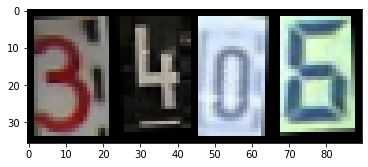

    3     4     0     6


In [5]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(cv2.cvtColor(np.transpose(npimg, (1, 2, 0)), cv2.COLOR_BGR2RGB))
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % labels[j].item() for j in range(4)))

# Train

In [6]:
def calculate_accuracy(loader):
    correct, total = 0, 0
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            for img, label in zip(images, labels):
                output = net(img.unsqueeze(0))
                predicted = torch.max(output, 1).indices[0].item()
                total += 1
                if predicted == label:
                    correct += 1
    return correct, total

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: %s" % (device))

best_model = None
best_model_accuracy = -1.0
net = Net()
net.to(device)
summary(net, input_size=(3, 32, 20))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

running_loss = 0.0
start_time = time.time()
for epoch in range(150):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print("Epoch %d, batch %d, runnig_loss %.3f, loss %.3f" % (epoch, i, running_loss, loss.item()))
    running_loss = 0
    
    correct, total = calculate_accuracy(trainloader)
    print("  Train: Correct %d, Total %d, Accuracy %.3f" % (correct, total, float(correct) / total))
    
    correct, total = calculate_accuracy(testloader)
    test_accuracy = float(correct) / total
    print("  Test: Correct %d, Total %d, Accuracy %.3f" % (correct, total, test_accuracy))
    if test_accuracy > best_model_accuracy:
        print("Saving new best model")
        best_model_accuracy = test_accuracy
        best_model = deepcopy(net.state_dict())

    #if epoch == 50:
    #    print("Reducing learning rate..")
    #    optimizer.lr = 5e-4      
print("Total time: %.3f" % (time.time() - start_time))

Device: cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 20]               6
            Conv2d-2           [-1, 32, 32, 20]             896
         MaxPool2d-3           [-1, 32, 16, 10]               0
            Conv2d-4           [-1, 64, 16, 10]          18,496
         MaxPool2d-5             [-1, 64, 8, 5]               0
            Conv2d-6             [-1, 64, 8, 5]          36,928
         MaxPool2d-7             [-1, 64, 4, 2]               0
            Linear-8                  [-1, 512]         262,656
            Linear-9                   [-1, 11]           5,643
Total params: 324,625
Trainable params: 324,625
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.34
Params size (MB): 1.24
Estimated Total Size (MB): 1.58
----------------------------

# Test

In [7]:
net = Net()
net.load_state_dict(best_model)
net.to(device)
correct, total = calculate_accuracy(testloader)
print("Correct %d, Total %d, Accuracy %.3f" % (correct, total, float(correct) / total))

Correct 178, Total 186, Accuracy 0.957


Predicted 10, Label 8, confidence 56.22 %, ['0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '43.8 %', '0.0 %', '56.2 %']
Predicted 10, Label 6, confidence 99.26 %, ['0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.7 %', '0.0 %', '0.0 %', '0.0 %', '99.3 %']
Predicted 1, Label 10, confidence 99.84 %, ['0.0 %', '99.8 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.2 %']
Predicted 1, Label 7, confidence 93.66 %, ['0.0 %', '93.7 %', '0.0 %', '0.2 %', '0.0 %', '0.0 %', '0.0 %', '6.1 %', '0.0 %', '0.0 %', '0.0 %']
Predicted 1, Label 10, confidence 99.68 %, ['0.0 %', '99.7 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.3 %']
Predicted 6, Label 10, confidence 99.97 %, ['0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '100.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %']
Predicted 10, Label 7, confidence 74.13 %, ['0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '0.0 %', '25.8 %', '0.0 %', '0.0 %', 

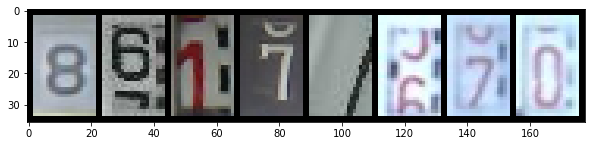

In [8]:
fp_images = []
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        for img, label in zip(images, labels):
            output = net(img.unsqueeze(0))
            predicted = torch.max(output, 1).indices[0].item()
            confidences = torch.nn.functional.softmax(output, 1).cpu().numpy()[0]
            if predicted != label:
                print("Predicted %d, Label %d, confidence %.2f %%, %s" % (predicted, label, 1e2 * confidences[predicted], ["%.1f %%" % (1e2 * c) for c in confidences]))
                fp_images.append(img.cpu())
  
plt.figure(figsize=(10, 10))
imshow(torchvision.utils.make_grid(fp_images, nrow=16))

# Save

In [9]:
print("Saved model accuracy: %.3f" % (best_model_accuracy))
torch.save(best_model, os.path.join("meter_digits_recognizer", "model_weights.pt"))

Saved model accuracy: 0.957
